<a href="https://colab.research.google.com/github/R-enanVieira/PlantIdentifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 1 - Tópicos Especiais em Matemática Aplicada

**Alunos/Matricula:** João V. Farias & Renan V. Guedes / 221022604 & 221031363

**Arquitetura Usada:** ResNet do zero

**Dataset Link:** [V1: Nonsegmented single plants (1.7GB)](https://vision.eng.au.dk/?download=/data/WeedData/Nonsegmented.zip)


### Rede Neural para determinar espécia de uma muda, dada sua imagem.

**Sobre o Dataset:** O dataset de mudas de plantas contém imagens de aproximadamente `960 plantas únicas` pertencentes a `12 espécies` em vários estágios de crescimento. Ele compreende imagens RGB anotadas com uma resolução física de aproximadamente `10 pixels por mm`.

Para o projeto, pensamos inicialmente em utilizar filtros, dos quais rapidamente abandonamos a ideia por ser complicado de mais criar uma função que removesse tantos fundos diferentes, alguns mais cinzas, outros mais claros; se pensassemos apenas em deixar o verde, havia uma boa chance de não pegar plantas mais "amareladas" ou perto do azul, então também não era uma escolha boa.

In [ ]:
from google.colab import drive

# Processamento de imagens

# from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Nonsegmented'
# dataset_path = '/content/drive/MyDrive/github/Nonsegmented'
# dataset_path = './Nonsegmented'

Mounted at /content/drive


# Tratamento dos dados

Para o projeto, pensamos inicialmente em utilizar filtros, dos quais rapidamente abandonamos a ideia por ser complicado de mais criar uma função que removesse tantos fundos diferentes, alguns mais cinzas, outros mais claros; se pensassemos apenas em deixar o verde, havia uma boa chance de não pegar plantas mais "amareladas" ou perto do azul, então também não era uma escolha boa.

- Redisionamento (uniformizar o tamanho das imagens) ☑️
- Normalização (valores dos pixels entre 0 e 1 `[dividir por 255]`) ☑️
- Data Augmentation (gerar variações das imagens `(rotações, espelhamentos, etc.)` para aumentar a diversidade do dataset) ☑️
- Separar Dataset em treino e teste ☑️

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import (
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomContrast,
    RandomTranslation
)

IMG_SIZE = 128
IMG_FIT = 128

train_generator = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    label_mode='categorical',
)

# Extract class labels from the train generator
class_labels = train_generator.class_names

validation_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 5544 files belonging to 12 classes.
Using 4436 files for training.
Found 5544 files belonging to 12 classes.
Using 1108 files for validation.


In [ ]:
# Construindo o modelo.
# Test the data augmentation pipeline on a batch of images
#for images, labels in train_generator.take(1):
#    augmented_images = data_augmentation(images, training=True)
#    break

import os

class_counts = {}

# Manually count the number of images in each subfolder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        class_counts[class_name] = len(os.listdir(class_path))

print("Class Counts:", class_counts)

Class Counts: {'Loose Silky-bent': 766, 'Scentless Mayweed': 607, 'Black-grass': 310, 'Cleavers': 335, 'Maize': 257, 'Common Chickweed': 713, 'Small-flowered Cranesbill': 576, 'Charlock': 452, 'Common wheat': 253, 'Sugar beet': 463, 'Fat Hen': 538, 'Shepherd’s Purse': 274}


## Desbalanceamento

Percebe-se que há um desbalanceamento muito grande, tendo classes de plantas com muito mais imagens, então como posível solução, utilizamos dum método padrão que é de calcular quantas imagens há, e então, utilizá-lo  para  calcular o peso de cada uma com a fórmula: quantidade de imagens dividido pelo número de classes e quantidade de imagens naquela class.


In [ ]:
# Compute class weights
from sklearn.utils import class_weight
import numpy as np

labels = []
for i, class_name in enumerate(class_counts.keys()):
    labels.extend([i] * class_counts[class_name])  # Append label indices

labels = np.array(labels)  # Flatten labels for sklearn
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)



Class Weights: {0: 0.6031331592689295, 1: 0.7611202635914333, 2: 1.4903225806451612, 3: 1.3791044776119403, 4: 1.7976653696498055, 5: 0.6479663394109397, 6: 0.8020833333333334, 7: 1.0221238938053097, 8: 1.826086956521739, 9: 0.9978401727861771, 10: 0.8587360594795539, 11: 1.686131386861314}


## Normalização usando Rescaling

In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = Rescaling(1.0 / 255)

train_generator = train_generator.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
)

validation_dataset = validation_dataset.map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
)


# Construção e Treinamento da NN

Os principais layers que podíamos pensar para o modelo:

- Conv2D: Para extrair características.
- Pooling (MaxPooling2D): Para reduzir dimensionalidade.
- Dropout: Para evitar overfitting.
- Dense: Para tomar decisões baseadas nas características extraídas.

Aos poucos fomos adicionando os outros blocos da ResNet, como os de resíduos mostrado por K. He em seu artigo de 2015.

### Construindo o Modelo


**Arquitetura do modelo:**

1. `Entrada:` recebe imagens redimensionadas para o tamanho definido por IMG_FIT (128 no seu código), com 3 canais de cor (RGB).

2. `Convolução e Pooling Iniciais:` extrai características da imagem usando uma camada de convolução, seguida por BatchNormalization, ReLU e MaxPooling para reduzir a dimensionalidade.

3. `Blocos Residuais:` o mais importante da arquitetura ResNet. Cada bloco residual contém duas camadas de convolução, BatchNormalization, ReLU e Dropout. Pegando mais característicias com as repetições e, é claro, minimizando o problema da perda de detalhes do gradiente.

4. `Empilhamento de Blocos:` blocos residuais são empilhados, com diferentes números de filtros e configurações de downsampling, para aprender representações hierárquicas das imagens.

5. `Global Average Pooling:` diminui dimensionalidade do mapa de características, calculando a média dos valores de cada filtro.

6. `Camada de Saída:` camada Dense com num_classes, neurônios e função de ativação softmax dá as probabilidades de cada classe, que é então utilizada para prever as imagens.


In [ ]:
# Imagens redimensionadas para 224x224 com 3 canais (RGB)
input_shape = (IMG_FIT, IMG_FIT, 3)

# Número de classes (baseado nas subpastas do dataset)
num_classes = 12

from tensorflow.keras import layers, models, optimizers

# Build a Custom ResNet Model
def build_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolution and Pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Residual Blocks
    def residual_block(x, filters, downsample=False):
        shortcut = x
        strides = (2, 2) if downsample else (1, 1)

        x = layers.Conv2D(filters, (3, 3), strides=strides, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(0.2)(x)  # Add dropout

        x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same")(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            shortcut = layers.Conv2D(filters, (1, 1), strides=(2, 2), padding="same")(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        x = layers.Dropout(0.2)(x)  # Add dropout
        return x

    # Stacking Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)
    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    # Global Average Pooling and Output Layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model



# Construir o modelo
resnet_model = build_resnet(input_shape, num_classes)
resnet_model.summary()

# Compilar o modelo
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 64)     │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)       

 Total params: 11,197,068 (42.71 MB)

 Trainable params: 11,187,468 (42.68 MB)

 Non-trainable params: 9,600 (37.50 KB)

### Treinando o Modelo e Aumento de Imagens (Augmentation)

Criamos uma sequência para fazer algumas transformações nas imagens de treino que temos, e assim aumentar a aleatoriedade e diminuir ainda mais o overfitting do modelo. Usamos também os pesos das classes calculado lá em cima. Imprimimos a perda e acurácia da validação.

In [ ]:
# Juntado os dois subsets de treino
# combined_train_dataset = augmented_train_dataset.concatenate(train_generator)

# rode 30 vezes no total?
epochs = 30

# Tudo e mais um pouco...
data_augmentation = tf.keras.Sequential([
    Resizing(IMG_FIT, IMG_FIT),
    #Rescaling(1.0 / 255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(0.2, 0.2)
])



train_aug = train_generator.map(lambda x, y: (data_augmentation(x), y))

# Train the model with class weights
history = resnet_model.fit(
    train_aug,
    validation_data=validation_dataset,
    epochs=epochs,
    class_weight=class_weights_dict,
)

# Avaliar no conjunto de validação
val_loss, val_accuracy = resnet_model.evaluate(validation_dataset)
print(f"Perda na validação: {val_loss}")
print(f"Acurácia na validação: {val_accuracy}")


Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 755s 5s/step - accuracy: 0.2439 - loss: 2.7964 - val_accuracy: 0.1552 - val_loss: 23.5654
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.4985 - loss: 1.5144 - val_accuracy: 0.2085 - val_loss: 6.0931
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 604s 4s/step - accuracy: 0.5687 - loss: 1.2646 - val_accuracy: 0.3051 - val_loss: 5.0040
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.5969 - loss: 1.2118 - val_accuracy: 0.3114 - val_loss: 4.2133
Epoch 5/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.6439 - loss: 1.0483 - val_accuracy: 0.3673 - val_loss: 3.2772
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 623s 4s/step - accuracy: 0.6714 - loss: 0.9526 - val_accuracy: 0.2518 - val_loss: 3.8735
Epoch 7/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - accuracy: 0.6949 - loss: 0.8882 - val_accuracy: 0.6444 - val_loss: 1.5422
Epoch 8/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.7150 - loss: 0.8270 - val_acc

# Avaliação e Teste

- Avaliação no set de Teste
- Matriz de Confusão
- Acurácia Geral

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


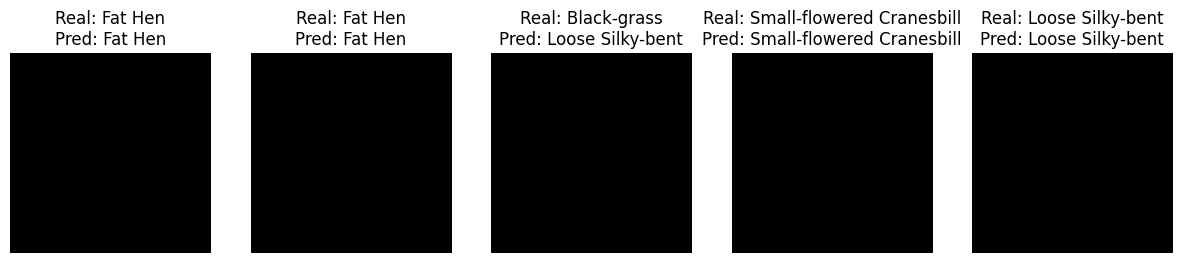

In [ ]:
#Exemplos de Classificação
import matplotlib.pyplot as plt
import numpy as np

# Função para plotar exemplos
def plot_classification_examples(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, (images, labels) in enumerate(dataset.take(1)):
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)

        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            plt.imshow(images[j].numpy().astype("uint8"))
            plt.title(f"Real: {class_names[true_classes[j]]}\nPred: {class_names[predicted_classes[j]]}")
            plt.axis("off")
        break
    plt.show()

plot_classification_examples(resnet_model, validation_dataset, class_labels)

### Matriz de Confusão

Como visto anteriromente,

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━

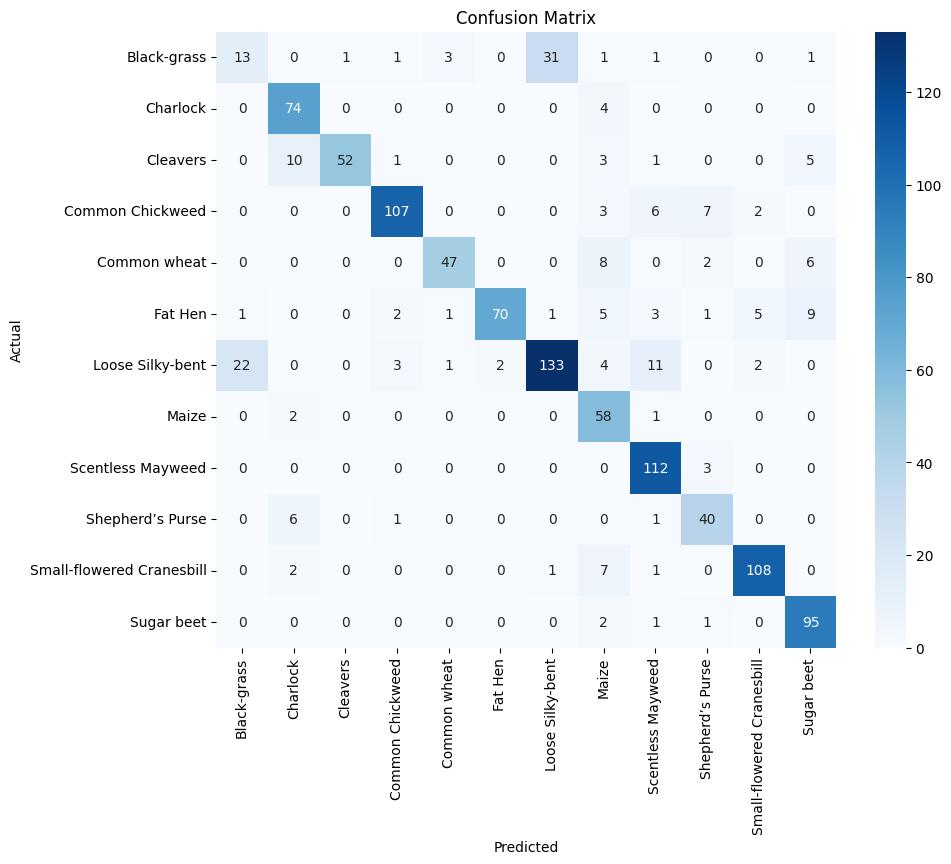

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Gerar predições e valores reais
y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = resnet_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Curva de Aprendizado

Ainda tendo minimizar overfitting, tentando dar mais peso para as classes mal-representadas, o modelo ainda tinha problemas ao olhar imagens com "estilos diferentes", causando uma variância média entre épocas na curva de acurácia da validação.

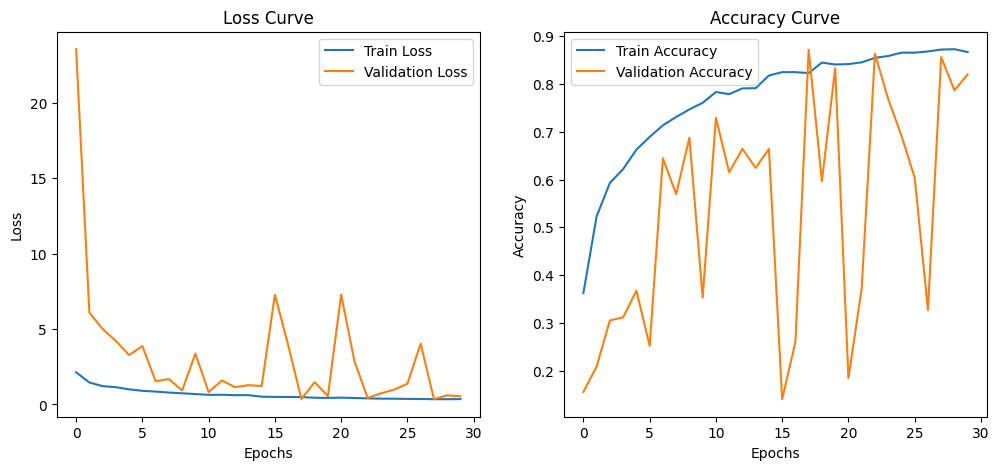

In [ ]:
# Plotar curva de aprendizado
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

# Chamar a função
plot_learning_curves(history)

### Análise de Erros

`Loose Silky-Bent` e `Black-grass` são duas classes muito, muito parecidas, talvez o problema fosse minimizado se aumentassemos a quantidade de épocas e adicionado mais alguns Dropouts para ele treinar ainda mais, apesar disso fazer o modelo ser mais lento para ser treinado, conseguíriamos classificações mais exatas.

`Common Chickweed` e `Shepherds's Purse` sofrem do mesmo problema, ambas se parecendo muito, mas uma delas tem duas folhas há mais como muda, sendo algo muito díficil de se perceber, e o modelo tendo problemas em retirar essa característica vital das imagens.

`Sugar beet` e `Fat Hen` são parecidos também, com uma tendo um centro um pouquinho mais distinguível do outro, então uma característica bem complicada de se encontrar.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


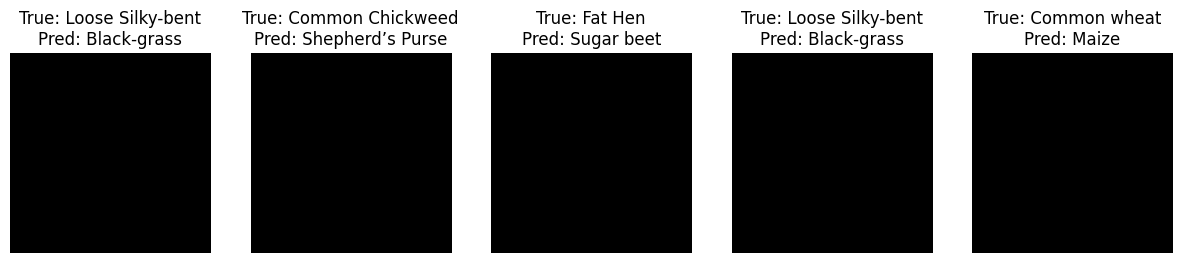

In [ ]:
#Exibir exemplos de erros
def plot_misclassified_images(model, dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 15))
    count = 0
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)

        for j in range(len(images)):
            if count >= num_images:
                break
            if predicted_classes[j] != true_classes[j]:
                plt.subplot(1, num_images, count + 1)
                plt.imshow(images[j].numpy().astype("uint8"))
                plt.title(f"True: {class_names[true_classes[j]]}\nPred: {class_names[predicted_classes[j]]}")
                plt.axis("off")
                count += 1
        break
    plt.show()

plot_misclassified_images(resnet_model, validation_dataset, class_labels)